In [ ]:
# Task 1.1
# Clock Granularity 

import time
import timeit
import numpy as np

def checktick_time_time(M):
	# M = 200
	timesfound = np.empty((M,))
	for i in range(M):
		t1 =  time.time() # get timestamp from timer
		t2 = time.time() # get timestamp from timer
		while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
			t2 = time.time() # get timestamp from timer
		t1 = t2 # this is outside the loop
		timesfound[i] = t1 # record the time stamp
	minDelta = 1000000
	Delta = np.diff(timesfound) # it should be cast to int only when needed
	minDelta = Delta.min()
	return minDelta

def checktick_timeit(M):
	# M = 200
	timesfound = np.empty((M,))
	for i in range(M):
		t1 =  timeit.default_timer() # get timestamp from timer
		t2 = timeit.default_timer() # get timestamp from timer
		while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
			t2 = timeit.default_timer() # get timestamp from timer
		t1 = t2 # this is outside the loop
		timesfound[i] = t1 # record the time stamp
	minDelta = 1000000
	Delta = np.diff(timesfound) # it should be cast to int only when needed
	minDelta = Delta.min()
	return minDelta

def checktick_time_time_ns(M):
	# M = 200
	timesfound = np.empty((M,))
	for i in range(M):
		t1 =  time.time_ns() # get timestamp from timer
		t2 = time.time_ns() # get timestamp from timer
		while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
			t2 = time.time_ns() # get timestamp from timer
		t1 = t2 # this is outside the loop
		timesfound[i] = t1 # record the time stamp
	minDelta = 1000000
	Delta = np.diff(timesfound) # it should be cast to int only when needed
	minDelta = Delta.min()
	return minDelta

M = 1000
cr1 = checktick_time_time(M)
cr2 = checktick_timeit(M)
cr3 = checktick_time_time_ns(M)

print("Clock granularity time.time(): ", cr1)
print("Clock granularity timeit.timer(): ", cr2)
print("Clock granularity time.time_ns(): ", cr3/1e9)

In [ ]:
# Task 1.2
# Timing the Julia set code functions

import time
import timeit
import numpy as np
from functools import wraps

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

# decorator to time
def timefn(fn):
    timings = []
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = timeit.default_timer()
        result = fn(*args, **kwargs)
        t2 = timeit.default_timer()
        elapsed_time = t2 - t1
        timings.append(elapsed_time)
        # print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    
    def get_timings():
        # Returns the list of all recorded timings.
        return timings

    def clear_timings():
        # Clears the list of recorded timings.
        timings.clear()
        
    def get_avg_std():
        m = np.average(timings)
        std = np.std(timings)
        return m,std    
        
    measure_time.get_timings = get_timings
    measure_time.clear_timings = clear_timings
    measure_time.get_avg_std = get_avg_std
    
    return measure_time

@timefn
def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    # start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    # end_time = time.time()
    # secs = end_time - start_time
    # print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    # This sum is expected for a 1000^2 grid with 300 iterations
    # It ensures that our code evolves exactly as we'd intended
    # assert sum(output) == 33219980

@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
calc_pure_python(desired_width=100, max_iterations=300)
calc_pure_python.clear_timings()
calculate_z_serial_purepython.clear_timings()

for _ in range(10):
	calc_pure_python(desired_width=100, max_iterations=300)

print("Recorded timings calc_pure_python: ", calc_pure_python.get_timings())
m,std = calc_pure_python.get_avg_std()
print("calc_pure_python avg: ", m, " - std: ", std)
print("Recorded timingscalculate_z_serial_purepython: ", calculate_z_serial_purepython.get_timings()) 
m,std = calculate_z_serial_purepython.get_avg_std()
print("calculate_z_serial_purepython avg: ", m, " - std: ", std)


In [ ]:
# Task 1.3 
# Profile the Julia set code with cProfile and line_profiler the computation

# cProfile
# python -m cProfile -s cumulative JuliaSet0.py
# python -m cProfile -o profile.stats JuliaSet0.py
# python -m snakeviz profile.stats --server

import pstats
p = pstats.Stats("profile.stats")
p.sort_stats("cumulative")
p.print_stats()


# line_profiler
# python -m kernprof -l JuliaSet1.py
# python -m line_profiler -rmt "JuliaSet1.py.lprof"


In [ ]:
# Task 1.4 
# Memory-profile the Juliaset code. Use the memory_profiler and mprof to profile the computation in JuliaSet code

# python -m memory_profiler JuliaSet2.py
# python -m mprof run JuliaSet2.py
# python -m mprof plot mprofile_***.dat

In [ ]:
# Task 2.1 
# Profile the diffusion code with cProfile and line_profiler the computation

# cProfile
# python -m cProfile -s cumulative diffusion0.py
# python -m cProfile -o diffusion.stats diffusion0.py
# python -m snakeviz diffusion.stats --server

import pstats
p = pstats.Stats("diffusion.stats")
p.sort_stats("cumulative")
p.print_stats()


# line_profiler
# python -m kernprof -l diffusion1.py
# python -m line_profiler -rmt "diffusion1.py.lprof"


In [ ]:
# Task 2.2
# Memory-profile the diffusion code. Use the memory_profiler and mprof to profile the computation

# python -m memory_profiler diffusion2.py
# python -m mprof run diffusion2.py
# python -m mprof plot mprofile_***.dat

Length of x: 100
Total elements: 10000
Length of x: 1000
Total elements: 1000000
calc_pure_python avg:  [92.24285714  5.46530612  3.3244898   3.50408163]  - std:  [23.41273855 10.94510516  6.79743441 11.0273863 ]
calculate_z_serial_purepython avg:  [95.03777778  5.66888889  3.13555556  3.31333333]  - std:  [18.79612595 11.44299538  6.86155653 10.59720299]


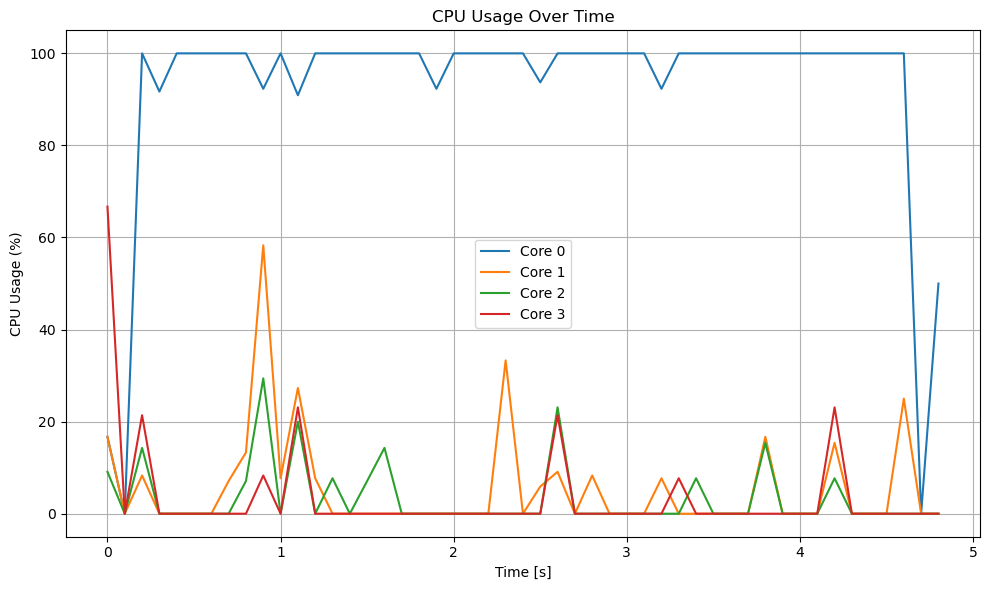

In [9]:
# Task 3
# Develop your profiler tool for monitoring CPU percentage use with psutil
import psutil, os
import multiprocessing as mp
import threading

import time
import timeit
from functools import wraps
import numpy as np
import matplotlib.pyplot as plt

# area of complex space to investigate
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

# decorator to time
def timefn(fn):
    timings = []
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = timeit.default_timer()
        result = fn(*args, **kwargs)
        t2 = timeit.default_timer()
        elapsed_time = t2 - t1
        timings.append(elapsed_time)
        # print(f"@timefn: {fn.__name__} took {t2 - t1} seconds")
        return result
    
    def get_timings():
        # Returns the list of all recorded timings.
        return timings

    def clear_timings():
        # Clears the list of recorded timings.
        timings.clear()
        
    def get_avg_std():
        m = np.average(timings)
        std = np.std(timings)
        return m,std    
        
    measure_time.get_timings = get_timings
    measure_time.clear_timings = clear_timings
    measure_time.get_avg_std = get_avg_std
    
    return measure_time

# decorator cpu monitor
def cpu_monitor(fn):
    cpu_percentages = []
    
    def monitor_cpu(manager,stop_flag):
        #cpu_p = np.zeros((1,4))
        cpu_p = np.array(psutil.cpu_percent(interval=0.1, percpu=True)).reshape((1,4))
        try:
            while not stop_flag.is_set():
                cpu_usage = psutil.cpu_percent(interval=0.1, percpu=True)
                cpu_p = np.vstack((cpu_p, np.array(cpu_usage)))
        except KeyboardInterrupt:
            pass
        finally:
            manager.put(cpu_p)
        return cpu_p

    @wraps(fn)
    def trace_cpu(*args, **kwargs):
        manager = mp.Queue()  # Queue to share return value between processes
        stop_flag = threading.Event()
        monitor_process = threading.Thread(target=monitor_cpu, args=(manager, stop_flag))
        monitor_process.start()
        try:
            result = fn(*args, **kwargs)
        finally:
            stop_flag.set()
        monitor_process.join()
        collected_data = manager.get()
        cpu_percentages.extend(collected_data)
        #print(cpu_percentages)
        return result
    
    def get_cpu_percentages():
        # Returns the list of all recorded timings.
        return np.array(cpu_percentages)
    def clear_cpu_percentages():
        # Returns the list of all recorded timings.
        cpu_percentages = []
    def get_avg_std():
        m = np.mean(np.array(cpu_percentages),axis=0)
        std = np.std(np.array(cpu_percentages),axis=0)
        return m,std
        
    trace_cpu.get_cpu_percentages = get_cpu_percentages
    trace_cpu.clear_cpu_percentages = clear_cpu_percentages
    trace_cpu.get_avg_std = get_avg_std 
    return trace_cpu

@cpu_monitor
def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))

    print("Length of x:", len(x))
    print("Total elements:", len(zs))
    # start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    # end_time = time.time()
    # secs = end_time - start_time
    # print(calculate_z_serial_purepython.__name__ + " took", secs, "seconds")

    # This sum is expected for a 1000^2 grid with 300 iterations
    # It ensures that our code evolves exactly as we'd intended
    # assert sum(output) == 33219980

@cpu_monitor
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

# Calculate the Julia set using a pure Python solution with
# reasonable defaults for a laptop
calc_pure_python(desired_width=100, max_iterations=300)
calc_pure_python.clear_cpu_percentages()
#calculate_z_serial_purepython.clear_cpu_percentages()

for _ in range(1):
	calc_pure_python(desired_width=1000, max_iterations=300)

#print("Recorded timings calc_pure_python: ", calc_pure_python.get_cpu_percentages())
m,std = calc_pure_python.get_avg_std()
print("calc_pure_python avg: ", m, " - std: ", std)
#print("Recorded timingscalculate_z_serial_purepython: ", calculate_z_serial_purepython.get_cpu_percentages()) 
m,std = calculate_z_serial_purepython.get_avg_std()
print("calculate_z_serial_purepython avg: ", m, " - std: ", std)


plt.figure(figsize=(10, 6))
cpu_data = calc_pure_python.get_cpu_percentages()
time_steps = np.arange(cpu_data.shape[0])  # Generate time steps based on rows
for i in range(cpu_data.shape[1]):  # Plot each CPU core's usage
    plt.plot(time_steps[:]*0.1, cpu_data[:, i], label=f'Core {i}')
    
plt.title('CPU Usage Over Time')
plt.xlabel('Time [s]')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


